Granting access to your dataset from the google drive location

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Verifying access and loading the first 5 rows

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Adjust this path to your Google Drive file structure
file_path = '/content/drive/My Drive/Intelligent Product Recommendation System for E-commerce/data/raw/2019-Oct.csv'

df = pd.read_csv(file_path, nrows=500000)
print("Shape of sample dataset:", df.shape)
df.head()


Shape of sample dataset: (500000, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


Cleaning and Transforming the Data - Convert event time, let's Drop rows with missing values in key columns, Score user actions (view, cart, purchase, etc)

In [3]:
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
df.dropna(subset=['product_id', 'category_id', 'event_time'], inplace=True)

event_score_map = {'view': 1, 'cart': 3, 'purchase': 5}
df['event_score'] = df['event_type'].map(event_score_map)

df[['event_type', 'event_score']].head(10)


,event_type,event_score
0,view,1
1,view,1
2,view,1
3,view,1
4,view,1
5,view,1
6,view,1
7,view,1
8,view,1
9,view,1


In [4]:
df.head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_score
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,1
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,1
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,1
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,1
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1
5,2019-10-01 00:00:05+00:00,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,1
6,2019-10-01 00:00:08+00:00,view,17300353,2053013553853497655,NaN,creed,380.96,555447699,4fe811e9-91de-46da-90c3-bbd87ed3a65d,1
7,2019-10-01 00:00:08+00:00,view,31500053,2053013558031024687,NaN,luminarc,41.16,550978835,6280d577-25c8-4147-99a7-abc6048498d6,1
8,2019-10-01 00:00:10+00:00,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,1
9,2019-10-01 00:00:11+00:00,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,1


Basic Visualizations to help understand the volume of events and popular products.

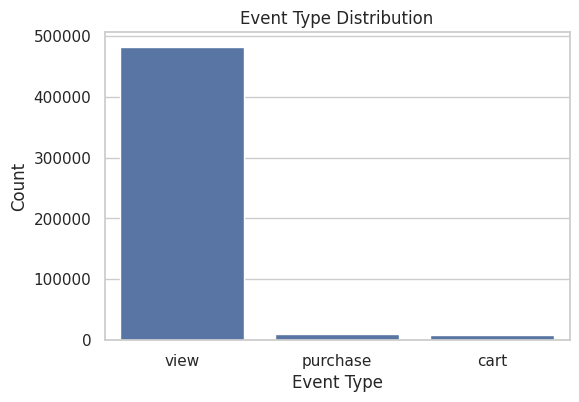

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='event_type', order=df['event_type'].value_counts().index)
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()


Let's now Visualize Top Products by Score

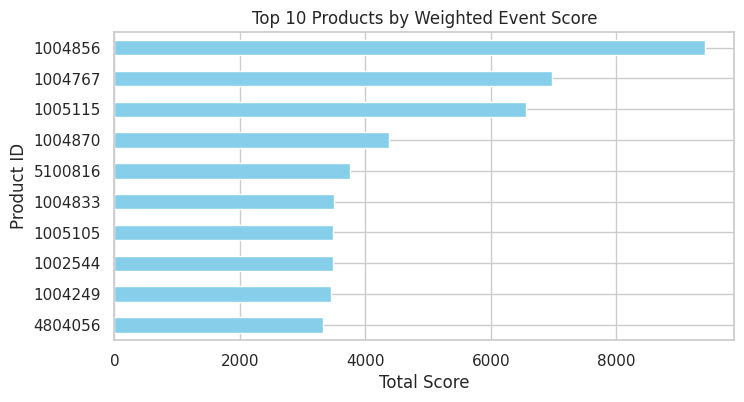

In [6]:
top_products = df.groupby('product_id')['event_score'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 4))
top_products.plot(kind='barh', color='skyblue')
plt.title('Top 10 Products by Weighted Event Score')
plt.xlabel('Total Score')
plt.ylabel('Product ID')
plt.gca().invert_yaxis()
plt.show()


Let's now filter out Top 200 Users and Top 200 Products & build the Sparse Matrix. Rows = users, Columns = products

In [7]:
top_users = df['user_id'].value_counts().head(200).index
top_products = df['product_id'].value_counts().head(200).index

df_top = df[df['user_id'].isin(top_users) & df['product_id'].isin(top_products)]

print("Filtered data shape:", df_top.shape)



Filtered data shape: (2159, 10)


In [8]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
product_enc = LabelEncoder()

df_top['user_idx'] = user_enc.fit_transform(df_top['user_id'])
df_top['product_idx'] = product_enc.fit_transform(df_top['product_id'])


/tmp/ipython-input-8-3874228306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['user_idx'] = user_enc.fit_transform(df_top['user_id'])
/tmp/ipython-input-8-3874228306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['product_idx'] = product_enc.fit_transform(df_top['product_id'])


In [9]:
from scipy.sparse import csr_matrix

rows = df_top['user_idx']
cols = df_top['product_idx']
data = df_top['event_score']

user_product_sparse = csr_matrix((data, (rows, cols)))

print("Sparse matrix shape:", user_product_sparse.shape)


Sparse matrix shape: (116, 179)


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between products (transpose to get item-item similarity)
product_similarity = cosine_similarity(user_product_sparse.T)

print("Similarity matrix shape:", product_similarity.shape)


Similarity matrix shape: (179, 179)


In [11]:
# Create reverse mapping from product index to actual product_id
product_id_map = dict(enumerate(product_enc.classes_))

# Example: what product ID corresponds to index 10
print("Example product at index 10:", product_id_map[10])


Example product at index 10: 1003310


In [12]:
def recommend_similar_products(product_id, top_n=5):
    if product_id not in product_enc.classes_:
        print("Product ID not found in training data.")
        return

    # Get internal index of the product
    product_idx = product_enc.transform([product_id])[0]

    # Get similarity scores for that product
    sim_scores = list(enumerate(product_similarity[product_idx]))

    # Sort by similarity score (excluding the product itself)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    print(f"\nTop {top_n} products similar to {product_id}:\n")
    for idx, score in sim_scores:
        similar_product_id = product_id_map[idx]
        print(f"Product ID: {similar_product_id} | Similarity Score: {score:.4f}")


In [13]:
example_product = df_top['product_id'].unique()[0]  # Or choose another
recommend_similar_products(example_product, top_n=5)



Top 5 products similar to 22700084:

Product ID: 22700068 | Similarity Score: 0.6860
Product ID: 1002099 | Similarity Score: 0.0000
Product ID: 1002524 | Similarity Score: 0.0000
Product ID: 1002528 | Similarity Score: 0.0000
Product ID: 1002544 | Similarity Score: 0.0000


In [14]:
# Use only purchase events for churn analysis
df_purchase = df[df['event_type'] == 'purchase'].copy()
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

df_purchase.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_score
162,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,5
308,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,5
379,2019-10-01 00:06:02+00:00,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,5
442,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,5
574,2019-10-01 00:09:26+00:00,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,5


In [15]:
# Last purchase date for each user
last_purchase = df_purchase.groupby('user_id')['event_time'].max().reset_index()
last_purchase.columns = ['user_id', 'last_purchase_date']
last_purchase.head()


,user_id,last_purchase_date
0,451971397,2019-10-01 09:37:14+00:00
1,453705583,2019-10-01 08:05:45+00:00
2,457360398,2019-10-01 04:22:53+00:00
3,469200473,2019-10-01 08:48:11+00:00
4,477366703,2019-10-01 06:39:55+00:00


In [16]:
# Get the last recorded date in the entire dataset
last_date = df['event_time'].max()
print("Latest event date in dataset:", last_date)

# Add churn flag
last_purchase['days_since_last_purchase'] = (last_date - last_purchase['last_purchase_date']).dt.days
last_purchase['churned'] = last_purchase['days_since_last_purchase'] > 14

# Show results
last_purchase.head()


Latest event date in dataset: 2019-10-01 10:22:43+00:00


,user_id,last_purchase_date,days_since_last_purchase,churned
0,451971397,2019-10-01 09:37:14+00:00,0,False
1,453705583,2019-10-01 08:05:45+00:00,0,False
2,457360398,2019-10-01 04:22:53+00:00,0,False
3,469200473,2019-10-01 08:48:11+00:00,0,False
4,477366703,2019-10-01 06:39:55+00:00,0,False


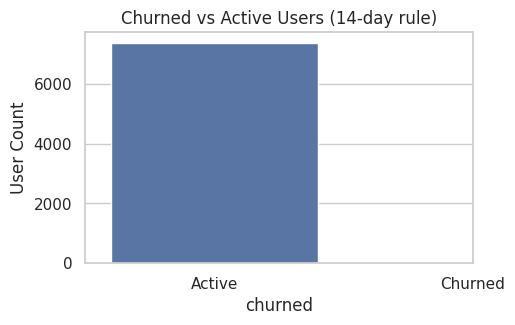

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
sns.countplot(data=last_purchase, x='churned')
plt.title('Churned vs Active Users (14-day rule)')
plt.xticks([0, 1], ['Active', 'Churned'])
plt.ylabel('User Count')
plt.show()


In [18]:
# We use product_id and category_id to define content similarity
product_features = df[['product_id', 'category_id']].drop_duplicates().dropna()

# Encode category_id
from sklearn.preprocessing import LabelEncoder
category_enc = LabelEncoder()
product_features['category_idx'] = category_enc.fit_transform(product_features['category_id'])

# Create product_id to content feature mapping
product_to_category = dict(zip(product_features['product_id'], product_features['category_idx']))


In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Create a one-hot encoded category matrix
num_products = len(product_enc.classes_)
num_categories = product_features['category_idx'].nunique()

content_matrix = np.zeros((num_products, num_categories))

for i, pid in enumerate(product_enc.classes_):
    cat = product_to_category.get(pid)
    if cat is not None:
        content_matrix[i, cat] = 1  # one-hot

# Compute cosine similarity on content matrix
content_similarity = cosine_similarity(content_matrix)

print("Content similarity shape:", content_similarity.shape)


Content similarity shape: (179, 179)


In [20]:
def hybrid_recommend(product_id, top_n=5, alpha=0.5):
    """
    alpha = weight for collaborative filtering (0.0 to 1.0)
    1 - alpha = weight for content-based filtering
    """
    if product_id not in product_enc.classes_:
        print("Product not found.")
        return

    idx = product_enc.transform([product_id])[0]

    # Get similarity vectors
    collab_sim = product_similarity[idx]
    content_sim = content_similarity[idx]

    # Weighted average
    hybrid_score = alpha * collab_sim + (1 - alpha) * content_sim

    # Get top N
    sim_scores = list(enumerate(hybrid_score))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    print(f"\nHybrid Recommendations for '{product_id}' (alpha={alpha}):\n")
    for idx, score in sim_scores:
        print(f"Product ID: {product_id_map[idx]} | Score: {score:.4f}")


In [21]:
example_product = df_top['product_id'].unique()[0]
hybrid_recommend(example_product, top_n=5, alpha=0.6)  # 60% collaborative, 40% content



Hybrid Recommendations for '22700084' (alpha=0.6):

Product ID: 22700068 | Score: 0.8116
Product ID: 22700129 | Score: 0.4000
Product ID: 1002099 | Score: 0.0000
Product ID: 1002524 | Score: 0.0000
Product ID: 1002528 | Score: 0.0000


In [22]:
import pickle
import numpy as np

# Save label encoder
with open("/content/drive/My Drive/Intelligent Product Recommendation System for E-commerce/app/product_enc.pkl", "wb") as f:
    pickle.dump(product_enc, f)

# Save index-to-ID mapping
with open("/content/drive/My Drive/Intelligent Product Recommendation System for E-commerce/app/product_id_map.pkl", "wb") as f:
    pickle.dump(product_id_map, f)

# Save collaborative similarity matrix
with open("/content/drive/My Drive/Intelligent Product Recommendation System for E-commerce/app/product_similarity.npy", "wb") as f:
    np.save(f, product_similarity)

# Save content-based similarity matrix
with open("/content/drive/My Drive/Intelligent Product Recommendation System for E-commerce/app/content_similarity.npy", "wb") as f:
    np.save(f, content_similarity)


In [23]:
# Show first 10 valid product IDs used in training
print(product_enc.classes_[:10])


[1002099 1002524 1002528 1002544 1002547 1002629 1002633 1002634 1003304
 1003306]


In [ ]:
!pip install streamlit cloudflared --quiet
!streamlit run "/content/drive/My Drive/Intelligent Product Recommendation System for E-commerce/app/streamlit_app.py" & npx cloudflared tunnel --url http://localhost:8501




⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.170.156.188:8501

⠴⠦⠧⠇2025-06-25T08:10:47Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-06-25T08:10:47Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-06-25T08:10:51Z INF +--------------------------------------------------------------------------------------------+
2025-06-25T08:10